In [ ]:
import pandas as pd

df = pd.read_csv("Mock_Parlay_Bet_Dataset.csv")
df.head()



In [ ]:
# Drop columns that won’t help the model for now
df = df.drop(columns=["player", "team", "parlay_id", "parlay_leg", "parlay_hit"])

# Encode 'location' as binary
df["is_home"] = df["location"].apply(lambda x: 1 if x == "Home" else 0)
df = df.drop(columns=["location", "opponent"])  # Drop for now (can one-hot later if needed)

# Features (X) and Target (y)
X = df[["avg_points", "line", "is_home"]]
y = df["hit"]


In [ ]:
# Redo train-test split and model training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))



In [ ]:
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print(coeffs.sort_values(by="Coefficient", ascending=False))


In [ ]:
sample_leg = X_test.iloc[0:1]
pred_prob = model.predict_proba(sample_leg)[0][1]
print(f"Predicted chance this leg hits: {round(pred_prob * 100, 2)}%")


In [ ]:
print("Sample input to model:\n", sample_leg)
print("Model coefficients:\n", model.coef_)
print("Predicted prob:\n", model.predict_proba(sample_leg)[0][1])


In [ ]:
pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)


In [ ]:
for i in range(5):
    leg = X_test.iloc[[i]]
    prob = model.predict_proba(leg)[0][1]
    print(f"Leg {i}: {round(prob * 100, 2)}%")


In [ ]:
# Simple model interpretation
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print(coeffs.sort_values(by="Coefficient", ascending=False))


In [ ]:
!pip install shap

In [ ]:
import pickle

# Load the trained model from disk
with open("logistic_model.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
import shap

def generate_shap_explanation(model, X_background, X_instance):
    """
    Generates an English explanation of SHAP values for a given instance.

    Parameters:
    - model: trained model (linear or tree-based)
    - X_background: training data (e.g., X_train)
    - X_instance: single-row DataFrame to explain

    Returns:
    - explanation: plain-English summary
    """
    # Choose correct explainer
    if "xgb" in model.__class__.__name__.lower():
        explainer = shap.Explainer(model, X_background)
    else:
        explainer = shap.explainers.Linear(model, X_background)

    shap_values = explainer(X_instance)
    contributions = shap_values.values[0]
    base_value = shap_values.base_values[0]
    prob = model.predict_proba(X_instance)[0][1]

    explanation = []
    explanation.append(f"🔍 Model predicts a hit probability of **{prob * 100:.2f}%** for this leg.")

    # Sort by impact
    impact_order = sorted(zip(X_instance.columns, X_instance.iloc[0], contributions),
                          key=lambda x: abs(x[2]), reverse=True)

    for feature, value, shap_val in impact_order:
        direction = "increased" if shap_val > 0 else "decreased" if shap_val < 0 else "had no impact on"
        explanation.append(f"- `{feature} = {value}` {direction} the probability by `{shap_val:.2f}`.")

    explanation.append(f"\n🧠 Most influential factor: `{impact_order[0][0]}` (SHAP = {impact_order[0][2]:.2f})")
    return "\n".join(explanation)


In [ ]:
explainer = shap.explainers.Linear(model, X_train)
shap_values = explainer(X_test.iloc[[0]])
shap.plots.waterfall(shap_values[0])
explanation = generate_shap_explanation(model, X_train, X_test.iloc[[0]])
print(explanation)

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap

# STEP 1: Load your data
df = pd.read_csv("Mock_Parlay_Bet_Dataset.csv")  # adjust if your file is named differently

# STEP 2: Clean and encode
df["is_home"] = df["location"].apply(lambda x: 1 if str(x).lower() == "home" else 0)

# Drop problematic or post-game columns
df = df.drop(columns=[
    "location",
    "actual_points",
    "player",     # you don't need the original player name if one-hot columns are gone
    "team",
    "opponent",
    "parlay_id",  # same for parlay_id
])

# Now create features
X = df.drop(columns=["hit"])
y = df["hit"]

# One-hot encode any leftover object columns (shouldn't be any now)
X = pd.get_dummies(X, drop_first=True)

# Final safety check (should pass now)
assert all(np.issubdtype(dtype, np.number) for dtype in X.dtypes), "Still contains non-numeric types"

# Continue with split, training, and SHAP
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test.iloc[[0]])
shap.plots.waterfall(shap_values[0])

explanation = generate_shap_explanation(model, X_train, X_test.iloc[[0]])
print(explanation)


In [ ]:
print(X_test.iloc[[0]])
print(generate_shap_explanation(model, X_train, X_test.iloc[[0]]))


In [ ]:
import plotly.express as px
import streamlit as st

# Example data: probability of parlay hitting over time
data = {
    "date": ["2024-06-01", "2024-06-05", "2024-06-10", "2024-06-15"],
    "probability": [0.35, 0.42, 0.58, 0.65]
}
df = pd.DataFrame(data)

fig = px.line(df, x="date", y="probability", title="Parlay Hit Probability Over Time")
st.plotly_chart(fig)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ✅ Step 1: Load and prepare data
df = pd.read_csv("full_nba_player_dataset.csv")

# ✅ Step 2: Define features and target
features = [
    'MIN', 'FGA', 'AST_x', 'REB_x',
    'avg_points_last_5', 'avg_assists_last_5',
    'days_rest', 'games_missed',
    'teammate_1_ppg', 'teammate_1_last5',
    'teammate_2_ppg', 'teammate_2_last5'
]
target = 'PTS_x'

# Ensure all features are numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# ✅ Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 4: Train models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# ✅ Step 5: Evaluate models
def evaluate(model, name):
    preds = model.predict(X_test)
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "R²": r2_score(y_test, preds)
    }

results = [
    evaluate(lr_model, "Linear Regression"),
    evaluate(rf_model, "Random Forest")
]

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
import shap
import numpy as np

# Step 1: Create SHAP explainer
explainer = shap.Explainer(rf_model, X_train)

# Step 2: Choose a test instance
i = 0  # You can change this to any index in your X_test
shap_values = explainer(X_test.iloc[[i]])

# Step 3: Plot waterfall
shap.plots.waterfall(shap_values[0])


In [ ]:
def explain_shap(shap_values, X_test, index):
    values = shap_values.values[index]
    base = shap_values.base_values[index]
    pred = base + values.sum()
    top_features = X_test.columns[np.argsort(np.abs(values))[::-1][:5]]
    
    print(f"\n🔍 Model predicts {pred:.2f} points for this game because:")
    for feat in top_features:
        impact = values[X_test.columns.get_loc(feat)]
        direction = "increased" if impact > 0 else "decreased"
        print(f"  • {feat} {direction} prediction by {abs(impact):.2f} points")


In [ ]:
explain_shap(shap_values, X_test, 0)


In [ ]:
import random

# Choose a random index from the test set
random_index = random.choice(X_test.index.tolist())

# Extract row and predict
X_instance = X_test.loc[[random_index]]
y_actual = y_test.loc[random_index]
y_pred = rf_model.predict(X_instance)[0]

print(f"🎯 Predicted points: {y_pred:.2f}")
print(f"✅ Actual points: {y_actual:.2f}")


In [ ]:
# Explain the prediction with SHAP
shap_values = explainer(X_instance)
shap.plots.waterfall(shap_values[0])


In [ ]:
def explain_shap(shap_values, X_test, index=None):
    values = shap_values.values[0]  # Only one instance
    base = shap_values.base_values[0]
    pred = base + values.sum()
    top_features = X_test.columns[np.argsort(np.abs(values))[::-1][:5]]
    
    print(f"\n🔍 Model predicted {pred:.2f} points because:")
    for feat in top_features:
        impact = values[X_test.columns.get_loc(feat)]
        direction = "increased" if impact > 0 else "decreased"
        print(f"  • {feat} {direction} prediction by {abs(impact):.2f} points")


In [ ]:
explain_shap(shap_values, X_instance)


In [ ]:
def explain_random_prediction_with_context(model, explainer, X_test, y_test, df_model_full):
    import random
    import numpy as np
    import shap

    # 1. Pick a random index
    random_index = random.choice(X_test.index.tolist())
    X_instance = X_test.loc[[random_index]]
    y_actual = y_test.loc[random_index]
    y_pred = model.predict(X_instance)[0]

    # 2. Match with full dataset to get context
    row_context = df_model_full.loc[random_index]
    player = row_context.get("player_name", "Unknown Player")
    game_date = row_context.get("GAME_DATE", "Unknown Date")
    opponent = row_context.get("opponent", "Unknown Opponent")
    is_home = row_context.get("is_home", 0)
    home_away = "Home" if is_home else "Away"

    # 3. Explain with SHAP
    shap_values = explainer(X_instance)

    # 4. Print full context
    print(f"\n📌 Game Info:")
    print(f"   • Player: {player}")
    print(f"   • Date: {game_date}")
    print(f"   • Opponent: {opponent}")
    print(f"   • Location: {home_away}")
    print(f"\n🎯 Model Prediction: {y_pred:.2f} points")
    print(f"✅ Actual Points: {y_actual:.2f}")

    # 5. Verbal explanation
    values = shap_values.values[0]
    base = shap_values.base_values[0]
    top_features = X_instance.columns[np.argsort(np.abs(values))[::-1][:5]]

    print(f"\n🔍 Breakdown of prediction:")
    for feat in top_features:
        impact = values[X_instance.columns.get_loc(feat)]
        direction = "increased" if impact > 0 else "decreased"
        print(f"  • {feat} {direction} prediction by {abs(impact):.2f} points")

    # 6. Show SHAP plot
    shap.plots.waterfall(shap_values[0])



In [ ]:
explain_random_prediction_with_context(rf_model, explainer, X_test, y_test, df_model)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load your dataset
df = pd.read_csv("full_nba_player_dataset.csv")

# Features and target
features = [
    'MIN', 'FGA', 'AST_x', 'REB_x',
    'avg_points_last_5', 'avg_assists_last_5',
    'days_rest', 'games_missed',
    'teammate_1_ppg', 'teammate_1_last5',
    'teammate_2_ppg', 'teammate_2_last5'
]
target = 'PTS_x'

# Convert features to numeric (fixes any string issues)
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Include context columns for later
context_cols = ["player_name", "GAME_DATE", "opponent", "is_home"]

# Drop NA and keep full info
df_model = df[features + [target] + context_cols].dropna()

# Split features/target
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save full test context
df_test_context = df_model.loc[X_test.index]


In [ ]:
# Train models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Evaluate
results = [
    {"Model": "Linear Regression", "MAE": mean_absolute_error(y_test, lr_model.predict(X_test)), "R²": r2_score(y_test, lr_model.predict(X_test))},
    {"Model": "Random Forest", "MAE": mean_absolute_error(y_test, rf_model.predict(X_test)), "R²": r2_score(y_test, rf_model.predict(X_test))}
]

pd.DataFrame(results)


In [ ]:
import shap
explainer = shap.Explainer(rf_model, X_train)


In [ ]:
def explain_random_prediction_with_context(model, explainer, X_test, y_test, df_test_context):
    import random
    import numpy as np
    import shap

    # Pick a random row from X_test
    random_index = random.choice(X_test.index.tolist())
    X_instance = X_test.loc[[random_index]]
    y_actual = y_test.loc[random_index]
    y_pred = model.predict(X_instance)[0]

    # Look up full game context
    context_row = df_test_context.loc[random_index]
    player = context_row.get("player_name", "Unknown Player")
    game_date = context_row.get("GAME_DATE", "Unknown Date")
    opponent = context_row.get("opponent", "Unknown Opponent")
    is_home = context_row.get("is_home", 0)
    location = "Home" if is_home else "Away"

    # Explain with SHAP
    shap_values = explainer(X_instance)

    # Print game info
    print(f"\n📌 Game Info:")
    print(f"   • Player: {player}")
    print(f"   • Date: {game_date}")
    print(f"   • Opponent: {opponent}")
    print(f"   • Location: {location}")
    print(f"\n🎯 Predicted Points: {y_pred:.2f}")
    print(f"✅ Actual Points:    {y_actual:.2f}")

    # Verbal feature explanation
    values = shap_values.values[0]
    base = shap_values.base_values[0]
    top_features = X_instance.columns[np.argsort(np.abs(values))[::-1][:5]]

    print(f"\n🔍 Why the model predicted that:")
    for feat in top_features:
        impact = values[X_instance.columns.get_loc(feat)]
        direction = "increased" if impact > 0 else "decreased"
        print(f"  • {feat} {direction} prediction by {abs(impact):.2f} points")

    # Show waterfall plot
    shap.plots.waterfall(shap_values[0])


In [ ]:
explain_random_prediction_with_context(rf_model, explainer, X_test, y_test, df_test_context)


In [ ]:
# Running linear regression and random forest on new csv without the inclusion of top two scoring teammates states

In [23]:
import pandas as pd

df = pd.read_csv("nba_player_augmented_dataset.csv")
df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,opponent,avg_points_last_5,avg_assists_last_5,trend_last_3_pts,days_rest,player_name,position,opp_points_allowed_to_position,opponent_def_rating,opponent_pace
0,22023,1630173,22301190,2024-04-14,NYK vs. CHI,W,19,2,3,0.667,...,CHI,NaN,NaN,NaN,2.0,Precious Achiuwa,SG,NaN,115.7,96.94
1,22023,1630173,22301175,2024-04-12,NYK vs. BKN,W,8,2,2,1.000,...,BKN,NaN,NaN,NaN,0.0,Precious Achiuwa,SG,NaN,115.7,96.94
2,22023,1630173,22301167,2024-04-11,NYK @ BOS,W,16,1,6,0.167,...,BOS,NaN,NaN,NaN,0.0,Precious Achiuwa,SG,NaN,115.7,96.94
3,22023,1630173,22301139,2024-04-07,NYK @ MIL,W,5,0,1,0.000,...,MIL,NaN,NaN,NaN,0.0,Precious Achiuwa,SG,NaN,115.7,96.94
4,22023,1630173,22301119,2024-04-05,NYK @ CHI,L,19,0,2,0.000,...,CHI,NaN,NaN,-1.333333,0.0,Precious Achiuwa,SG,NaN,115.7,96.94


In [24]:
# Drop rows with any missing values in selected features/target
features = [
    "MIN", "FGA", "AST", "REB",
    "avg_points_last_5", "avg_assists_last_5",
    "trend_last_3_pts", "days_rest", "is_home",
    "opponent_def_rating", "opponent_pace", "opp_points_allowed_to_position"
]

target = "PTS"  # or "actual_points" if that's what your dataset uses

df_model = df[features + [target]].dropna(subset=[target])
X = df_model[features].fillna(0)  # fill missing values with 0 or mean if needed
y = df_model[target]

# Now do the train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Next Step is training the XGBoost model
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [31]:
results = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "MAE": mean_absolute_error(y_test, lr_preds),
        "R²": r2_score(y_test, lr_preds)
    },
    {
        "Model": "Random Forest",
        "MAE": mean_absolute_error(y_test, rf_preds),
        "R²": r2_score(y_test, rf_preds)
    }, 
    {
        "Model": "XG Boost", 
        "MAE": mean_absolute_error(y_test, xgb_pred),
        "R²": r2_score(y_test, xgb_pred)
    }
])

results


,Model,MAE,R²
0,Linear Regression,2.953322,0.814078
1,Random Forest,3.018657,0.806149
2,XG Boost,2.928996,0.815734


🎯 Player: Dorian Finney-Smith
🗓️ Game vs CHA on 2023-11-30
🔮 Predicted points: 11.57
✅ Actual points scored: 14

🔍 SHAP explanation (top 5 features):

  • FGA: ↓ -1.65 impact
  • MIN: ↑ 1.16 impact
  • REB: ↑ 0.54 impact
  • avg_assists_last_5: ↑ 0.37 impact
  • avg_points_last_5: ↓ -0.33 impact


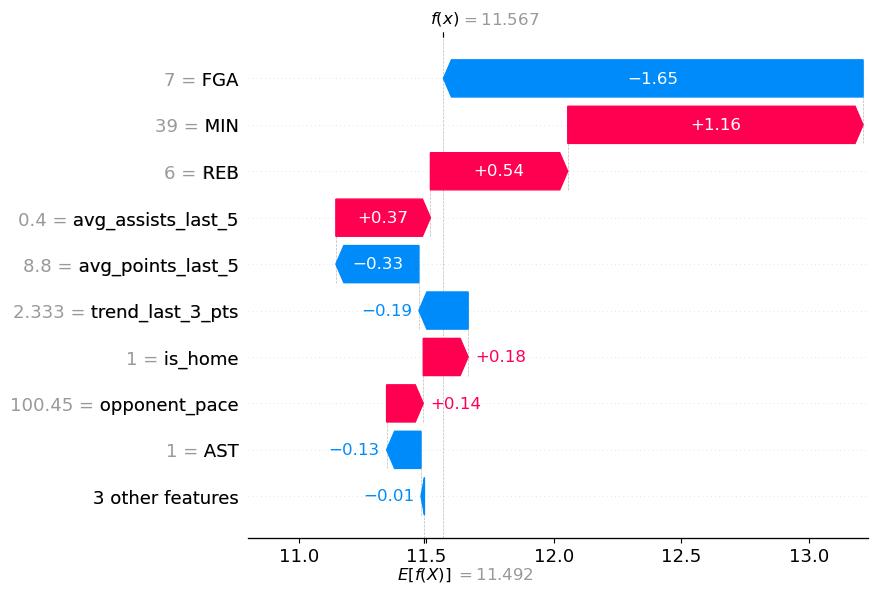

In [78]:
import shap
import random

# ------------------------
# Train SHAP Explainer
# ------------------------
explainer = shap.Explainer(rf_model, X_train)

# ------------------------
# Randomly Pick Player + Game
# ------------------------
# Merge model inputs with identifiers
X_test_with_meta = X_test.copy()
X_test_with_meta["player_name"] = df.iloc[X_test.index]["player_name"].values
X_test_with_meta["actual_pts"] = df.iloc[X_test.index]["PTS"].values
X_test_with_meta["opponent"] = df.iloc[X_test.index]["opponent"].values
X_test_with_meta["game_date"] = df.iloc[X_test.index]["GAME_DATE"].values

# Choose a random row
row = X_test_with_meta.sample(1).reset_index(drop=True)
row_features = row[rf_model.feature_names_in_]
player_name = row["player_name"].iloc[0]
opponent = row["opponent"].iloc[0]
game_date = row["game_date"].iloc[0]
actual_pts = row["actual_pts"].iloc[0]

# ------------------------
# Predict and Explain
# ------------------------
shap_values = explainer(row_features, check_additivity = False)
predicted_pts = rf_model.predict(row_features)[0]
base_value = shap_values.base_values[0]
contributions = shap_values.values[0]

# Sort feature impacts
ranked = sorted(zip(features, contributions), key=lambda x: abs(x[1]), reverse=True)

# ------------------------
# Output
# ------------------------
print(f"🎯 Player: {player_name}")
print(f"🗓️ Game vs {opponent} on {game_date}")
print(f"🔮 Predicted points: {predicted_pts:.2f}")
print(f"✅ Actual points scored: {actual_pts}")
print("\n🔍 SHAP explanation (top 5 features):\n")
for feat, contrib in ranked[:5]:
    direction = "↑" if contrib > 0 else "↓"
    print(f"  • {feat}: {direction} {contrib:.2f} impact")

# Optional: SHAP waterfall plot
shap.plots.waterfall(shap_values[0])


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

df = pd.read_csv("nba_predictive_rolling_dataset.csv")

# Features and Target: 
features = [
    "avg_min_last_5", "avg_fgm_last_5", "avg_fga_last_5", "avg_fg_pct_last_5",
    "avg_fg3m_last_5", "avg_fg3a_last_5", "avg_fg3_pct_last_5", "avg_ftm_last_5", 
    "avg_fta_last_5", "avg_ft_pct_last_5", "avg_oreb_last_5", 
    "avg_pts_last_5", "days_rest", "is_home", 
    "DEF_RATING", "PACE"
]

# Set your target
target = "actual_pts"

# Select only the columns that we care about
df_model = df[features + [target]].dropna(subset = [target])

# X serves as the feature matrix, filling all NaN values with 0
# Y serves as the target vector
X = df_model[features].fillna(0)
Y = df_model[target]

# this is the train_test_split step
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# The next step is training the Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

# Next step is training the Random Forest Model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)

# Next Step is training the XGBoost model
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_test)


In [33]:
results = pd.DataFrame([
    {
        "Model": "Linear Regression", 
        "MAE": mean_absolute_error(Y_test, lr_pred),
        "R^2": r2_score(Y_test, lr_pred)
    },
    {
        "Model": "Random Forest", 
        "MAE": mean_absolute_error(Y_test, rf_pred),
        "R^2": r2_score(Y_test, rf_pred)  
    }, 
    {
        "Model": "XG Boost", 
        "MAE": mean_absolute_error(Y_test, xgb_pred),
        "R^2": r2_score(Y_test, xgb_pred)
    }
])

results

,Model,MAE,R^2
0,Linear Regression,4.512558,0.567295
1,Random Forest,4.637364,0.548415
2,XG Boost,4.553622,0.556936


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

df = pd.read_csv("nba_merged_with_defense_final.csv")

# Features and Target: 
features = [
    "avg_min_last_5", "avg_fgm_last_5", "avg_fga_last_5", "avg_fg_pct_last_5",
    "avg_fg3m_last_5", "avg_fg3a_last_5", "avg_fg3_pct_last_5", "avg_ftm_last_5", 
    "avg_fta_last_5", "avg_ft_pct_last_5", "avg_reb_last_5", 
    "avg_pts_last_5", "days_rest", "is_home"
]

# Set your target
target = "actual_pts"

# Select only the columns that we care about
df_model = df[features + [target]].dropna(subset = [target])

# X serves as the feature matrix, filling all NaN values with 0
# Y serves as the target vector
X = df_model[features].fillna(0)
Y = df_model[target]

# this is the train_test_split step
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# The next step is training the Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

# Next step is training the Random Forest Model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)

# Next Step is training the XGBoost model
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_test)


ValueError: could not convert string to float: '63.4%'

In [3]:
results = pd.DataFrame([
    {
        "Model": "Linear Regression", 
        "MAE": mean_absolute_error(Y_test, lr_pred),
        "R^2": r2_score(Y_test, lr_pred)
    },
    {
        "Model": "Random Forest", 
        "MAE": mean_absolute_error(Y_test, rf_pred),
        "R^2": r2_score(Y_test, rf_pred)  
    }, 
    {
        "Model": "XG Boost", 
        "MAE": mean_absolute_error(Y_test, xgb_pred),
        "R^2": r2_score(Y_test, xgb_pred)
    }
])

results

,Model,MAE,R^2
0,Linear Regression,4.809896,0.484281
1,Random Forest,4.912657,0.464085
2,XG Boost,4.849342,0.473618


In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

df = pd.read_csv("nba_merged_with_defense_final.csv")
df["opp_efficiency_score"] = df["points_per_game_Last 3"] / df["field_goals_attempted_per_game_Last 3"]
df["defensive_pressure"] = df["points_per_game_Last 3"] + 0.1 * df["field_goals_attempted_per_game_Last 3"]


# Features and Target: 
features = [
    "avg_pts_last_5", "avg_min_last_5", "avg_ft_pct_last_5", 
    "avg_ast_last_5", "avg_tov_last_5", "avg_fg3_pct_last_5", 
    "avg_fg_pct_last_5", "avg_reb_last_5", "avg_stl_last_5",
    "avg_pf_last_5", "avg_blk_last_5", "avg_plus_minus_last_5",
    "days_rest", "is_home",

    # select defensive stats (low collinearity, marginal gains)
    "defensive_pressure"
]




# Set your target
target = "actual_pts"

# Select only the columns that we care about
df_model = df[features + [target]].dropna(subset = [target])

for col in features:
    if df_model[col].dtype == 'object' and df_model[col].str.contains('%').any():
        df_model[col] = df_model[col].str.replace('%', '').astype(float) / 100

# X serves as the feature matrix, filling all NaN values with 0
# Y serves as the target vector
X = df_model[features].fillna(0)
Y = df_model[target]

# this is the train_test_split step
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# The next step is training the Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

# Next step is training the Random Forest Model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)

# Next Step is training the XGBoost model
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_test)

# Train the Ridge Regression Model

ridge = Ridge(alpha=10.0)  # start with 1.0, then tune
ridge.fit(X_train, Y_train)
ridge_pred = ridge.predict(X_test)


In [89]:
results = pd.DataFrame([
    {
        "Model": "Linear Regression", 
        "MAE": mean_absolute_error(Y_test, lr_pred),
        "R^2": r2_score(Y_test, lr_pred)
    },
    {
        "Model": "Random Forest", 
        "MAE": mean_absolute_error(Y_test, rf_pred),
        "R^2": r2_score(Y_test, rf_pred)  
    }, 
    {
        "Model": "XG Boost", 
        "MAE": mean_absolute_error(Y_test, xgb_pred),
        "R^2": r2_score(Y_test, xgb_pred)
    }, 
    {
        "Model": "Ridge", 
        "MAE": mean_absolute_error(Y_test, ridge_pred),
        "R^2": r2_score(Y_test, ridge_pred)
    }, 
])

results

,Model,MAE,R^2
0,Linear Regression,4.913421,0.491298
1,Random Forest,4.972049,0.483877
2,XG Boost,4.914335,0.490697
3,Ridge,4.912792,0.491330


In [90]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X, Y, cv=5, scoring='neg_mean_absolute_error')
print(f"Avg MAE: {-scores.mean()}")

Avg MAE: 4.823402050634321


In [81]:
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains('%').any():
        df[col] = df[col].str.replace('%', '').astype(float)
corr_matrix = df[features + [target]].corr()
print(corr_matrix["actual_pts"].sort_values(ascending=False))


actual_pts               1.000000
avg_pts_last_5           0.695240
avg_min_last_5           0.612065
avg_tov_last_5           0.546754
avg_ft_pct_last_5        0.533268
avg_ast_last_5           0.525018
avg_reb_last_5           0.372612
avg_stl_last_5           0.307306
avg_pf_last_5            0.292478
avg_fg3_pct_last_5       0.237001
avg_fg_pct_last_5        0.207984
avg_blk_last_5           0.163120
avg_plus_minus_last_5    0.108692
defensive_pressure       0.013951
is_home                  0.001364
days_rest               -0.065973
Name: actual_pts, dtype: float64


Text(0.5, 1.0, 'Random Forest Feature Importances')

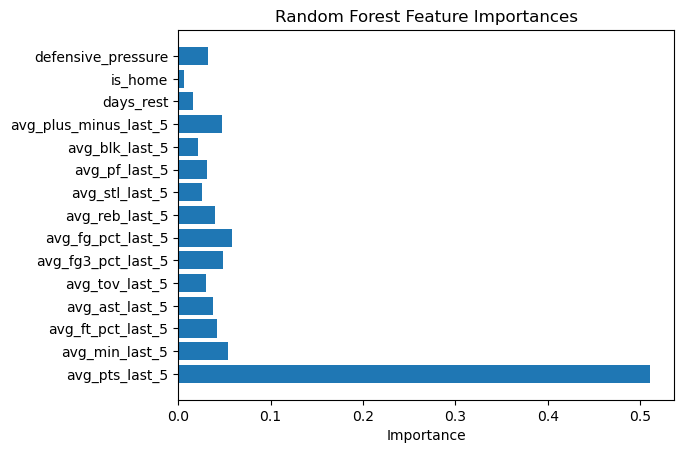

In [82]:
import matplotlib.pyplot as plt
importances = rf_model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Assume X is your DataFrame with features only (no target column)
X_vif = X.copy()
X_vif = add_constant(X_vif)  # Adds intercept for statsmodels

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display sorted VIF values
vif_data.sort_values("VIF", ascending=False)


,feature,VIF
0,const,28.615034
1,avg_pts_last_5,5.478491
2,avg_min_last_5,5.189154
5,avg_tov_last_5,2.827992
4,avg_ast_last_5,2.694521
8,avg_reb_last_5,2.345010
3,avg_ft_pct_last_5,2.245822
10,avg_pf_last_5,1.639866
6,avg_fg3_pct_last_5,1.554535
9,avg_stl_last_5,1.458252
